In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from datetime import date, datetime

from scipy import stats
import psychrolib
psychrolib.SetUnitSystem(psychrolib.IP)
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot

import helper_functions as hlp
%load_ext autoreload

# Initializing Data and Engineering Potentially Useful Features

In [2]:
# importing data
data = pd.read_csv('data/processed/data_clean.csv')

In [3]:
# converting times to datetimes
data['datetime_beginning_utc'] = pd.to_datetime(data['datetime_beginning_utc'])
data['datetime_beginning_ept'] = pd.to_datetime(data['datetime_beginning_ept'])

In [4]:
#inspecting data distributions
data.describe()

system_energy_price_rt  total_lmp_rt  congestion_price_rt  \
count            34272.000000  34272.000000         34272.000000   
mean                29.781416     32.943652             2.558594   
std                 21.901553     28.052319             9.231788   
min                -56.710000    -53.471480          -109.388085   
25%                 21.130625     22.667842             0.000000   
50%                 24.920834     27.184037             0.281446   
75%                 31.460000     33.952002             2.994807   
max                690.027500    953.119790           287.993853   

       marginal_loss_price_rt  system_energy_price_da  total_lmp_da  \
count            34272.000000            34272.000000  34272.000000   
mean                 0.603650               29.900499     33.416233   
std                  0.839235               14.851547     18.077154   
min                 -5.326984                2.270000      4.636074   
25%                  0.224707               22.000000     23.973685   
50%                  0.448074               26.750000     29.624175   
75%                  0.763428               33.922500     37.940619   
max                 27.531492              294.830000    385.995223   

       congestion_price_da  marginal_loss_price_da      pepco_mw  \
count         34272.000000            34272.000000  34272.000000   
mean              2.934671                0.581063   3034.175280   
std               4.482049                0.618494    657.966618   
min             -41.624613               -1.382850   1812.757000   
25%               0.515682                0.236300   2576.607000   
50%               1.795321                0.472536   2921.162000   
75%               3.890153                0.781039   3393.367000   
max              95.276622               11.172696   5813.240000   

          midatl_mw  midatl_forecast_load_mw  midatl_forecast_load_mw_final  \
count  34272.000000             34272.000000                   34272.000000   
mean   31166.241383             31516.781221                   31562.984302   
std     6451.354170              6286.761758                    6449.531864   
min    18974.639000             19717.000000                   19348.000000   
25%    26798.874750             27311.000000                   27196.750000   
50%    30084.413500             30542.000000                   30494.500000   
75%    34576.681500             34800.000000                   34953.250000   
max    56721.425000             58561.000000                   57622.000000   

       apsouth_flow_mw  apsouth_limit_mw  bcpep_flow_mw  bcpep_limit_mw  \
count     34272.000000      34272.000000   34272.000000    34272.000000   
mean       2096.609856       3450.271359    3565.579599     5556.293768   
std         888.355699        669.497703    1156.170126      794.008862   
min        -382.000000       1100.000000     165.000000     2300.000000   
25%        1467.000000       3000.000000    2705.000000     5000.000000   
50%        2019.000000       3500.000000    3564.000000     5600.000000   
75%        2621.000000       3900.000000    4377.000000     6100.000000   
max        5677.000000       6100.000000    7200.000000     7800.000000   

       bed_bla_flow_mw  bed_bla_limit_mw  central_flow_mw  central_limit_mw  \
count     34272.000000      34272.000000     34272.000000      34272.000000   
mean        887.282534       1423.061099      -903.382907       3151.639823   
std         367.112809        227.366427      1214.993236        899.972964   
min        -602.000000          0.000000     -3596.000000        200.000000   
25%         637.000000       1300.000000     -1749.000000       2500.000000   
50%         855.000000       1400.000000     -1106.000000       3100.000000   
75%        1118.000000       1524.998702      -325.750000       3800.000000   
max        2000.000000       2400.000000      4843.000000       5500.000000   

       east_flow_mw  east_limit_mw  west_

In [5]:
# creating a feature that is the spread/delta between the interface flows and limits
data['apsouth_spread_mw'] = data['apsouth_limit_mw'] - data['apsouth_flow_mw']
data['bcpep_spread_mw'] = data['bcpep_limit_mw'] - data['bcpep_flow_mw']
data['bed_bla_spread_mw'] = data['bed_bla_limit_mw'] - data['bed_bla_flow_mw']
data['central_spread_mw'] = data['central_limit_mw'] - data['central_flow_mw']
data['east_spread_mw'] = data['east_limit_mw'] - data['east_flow_mw']
data['west_spread_mw'] = data['west_limit_mw'] - data['west_flow_mw']

In [6]:
# calculating enthalpy (measure of total energy) of the air
# converting pressure to psi to comply with psychrolib requirements
data['pressure'] = data['pressure'] * 0.0145038

In [7]:
# calculating intermediate metric of Humidity Ratio
data['humidity_ratio'] = data[['dewPoint', 'pressure']].apply(lambda x: 
                                                              psychrolib.GetHumRatioFromTDewPoint(x['dewPoint'],
                                                                                                  x['pressure']),
                                                              axis=1)


In [8]:
# calculating the Enthalpy
data['enthalpy'] = data[['temperature', 'humidity_ratio']].apply(lambda x:
                                                                 psychrolib.GetMoistAirEnthalpy(x['temperature'],
                                                                                                x['humidity_ratio']),
                                                                 axis=1)

In [9]:
# calculating degree days for the heating and cooling season
# to decouple the temperature effects in the summer and winter
# apparentTemperature was found to be better used for comparison
# than actual temperature
# 65 is the industry default baseline temperature
CDD_BASE_TEMP = 65
HDD_BASE_TEMP = 65

In [10]:
# creating cooling degree days
data['CDD'] = data['apparentTemperature'].apply(lambda x: max(round((x-CDD_BASE_TEMP)/24,2),0))

In [11]:
# creating heating degree days
data['HDD'] = data['apparentTemperature'].apply(lambda x: max(round((HDD_BASE_TEMP-x)/24,2),0))

In [12]:
# sum of heating and cooling degree days
data['DD'] = data['CDD']+data['HDD']

In [13]:
# generating dummy variables for categorical columns (i.e. precipitation Type)
data = pd.get_dummies(data)

In [14]:
# defining on/off peak hours, which are defined by PJM/NERC
data['date'] = data['datetime_beginning_ept'].dt.date
data['hour'] = data['datetime_beginning_ept'].dt.hour
data['dayofweek'] = data['datetime_beginning_ept'].dt.dayofweek
data['dayofyear'] = data['datetime_beginning_ept'].dt.dayofyear

data['peak_hour'] = data.apply(lambda x: hlp.is_peak(x),
                               axis=1)

In [15]:
# generating circular time for potential use as a regressor 
# (i.e delta between 23rd and 0 hour are the same as 0 hour and 1st hour)
data = hlp.encode_circular_time(data, 'hour')
data = hlp.encode_circular_time(data, 'dayofweek')
data = hlp.encode_circular_time(data, 'dayofyear')

In [16]:
# EDA will be performed using the 2016-2018 data in an attempt to reduce data leakage
train_data = data.loc[data['datetime_beginning_ept'] < pd.Timestamp(2019, 1, 1)].copy()

# Analyzing Stationarity and Autocorrelation
Dickey-Fuller Test for stationarity had p-values well below 1%, so we can reject the null hypothesis and assume stationarity for both the LMP and MW time series.  
  
Autocorrelation was very apparent for MW on short and long term time scales. Autocorrelation was only present back several days for LMP, yet there was a little seasonality as well. The MW time series should be easier to accurately forecast than the LMPs.

## Locational Marginal Prices (LMP), Real-Time

In [17]:
lmp_stationarity = adfuller(train_data['total_lmp_rt'].values)
print('Pepco Real-Time LMP p-value = ', lmp_stationarity[1])

Pepco Real-Time LMP p-value =  2.0341942556882126e-20


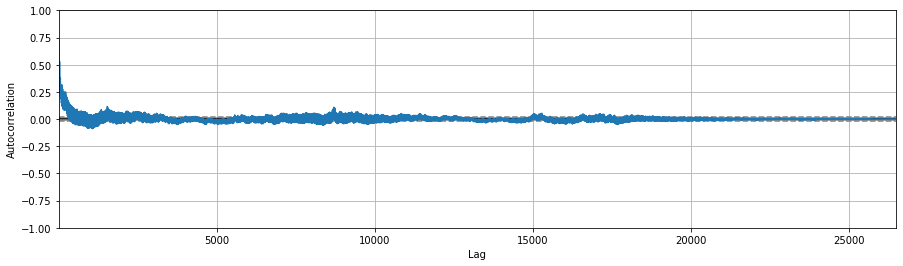

In [18]:
# evaluating autocorrelation over the entire time series shows mild patterns that trail off quickly
fig = plt.figure(figsize = [15, 4])
autocorrelation_plot(train_data['total_lmp_rt']);

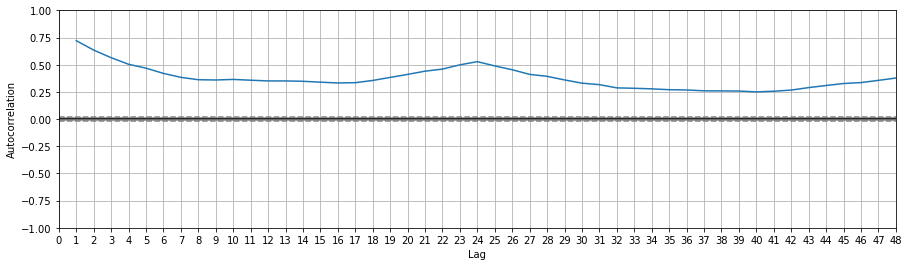

In [19]:
# Now just looking back 48 hours yields stronger short term patterns
fig = plt.figure(figsize = [15, 4])
autocorrelation_plot(train_data['total_lmp_rt'])
plt.gca().set_xlim(0,48)
plt.gca().set_xticks(range(0,49));

(0, 504)

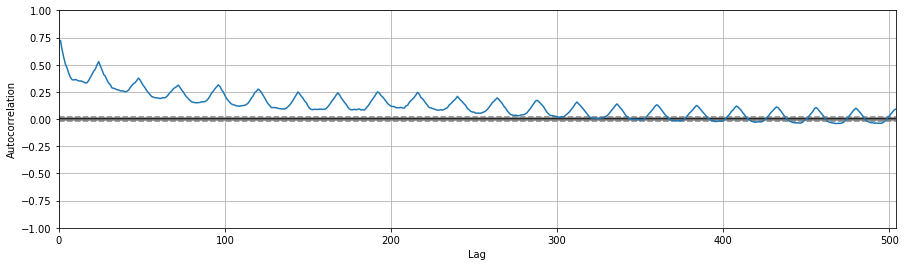

In [20]:
# Now just looking back 3 weeks hours yields short term patterns that begin to become negligible by week 2
fig = plt.figure(figsize = [15, 4])
autocorrelation_plot(train_data['total_lmp_rt'])
plt.gca().set_xlim(0,504)

## Load/Instantaneous Consumption (MW)

In [21]:
mw_stationarity = adfuller(train_data['pepco_mw'].values)
print('Pepco MW Time Series p-value = ', mw_stationarity[1])

Pepco MW Time Series p-value =  7.344622755441625e-17


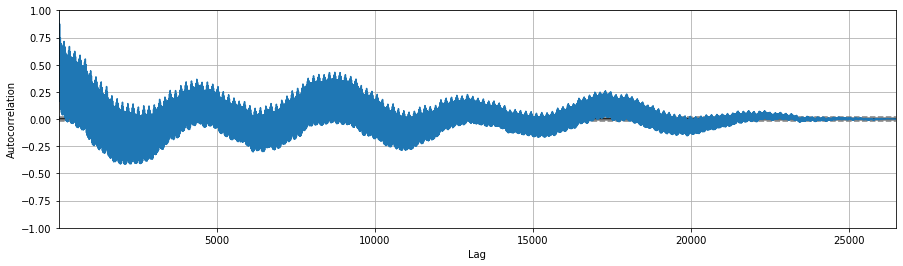

In [22]:
# evaluating autocorrelation shows significant patterns
fig = plt.figure(figsize = [15, 4])
autocorrelation_plot(train_data['pepco_mw']);

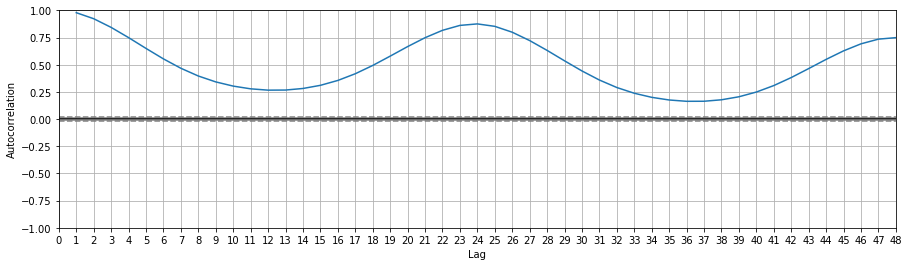

In [23]:
# Now just looking back 48 hours yields strong short term patterns
fig = plt.figure(figsize = [15, 4])
autocorrelation_plot(train_data['pepco_mw'])
plt.gca().set_xlim(0,48)
plt.gca().set_xticks(range(0,49));

(0, 672)

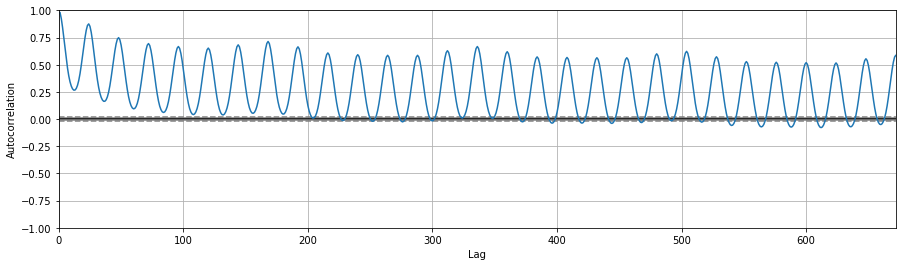

In [24]:
# Now just looking back 4 weeks hours yields short term patterns that largely persist
fig = plt.figure(figsize = [15, 4])
autocorrelation_plot(train_data['pepco_mw'])
plt.gca().set_xlim(0,672)

In [25]:
# standardizing data so it can be compared on a standard scale
# initializing the columns to standardize
cols_to_stdz = ['total_lmp_rt', 'system_energy_price_rt', 'congestion_price_rt',
                'marginal_loss_price_rt', 'total_lmp_da', 'system_energy_price_da',
                'congestion_price_da', 'marginal_loss_price_da',
                'pepco_mw', 'midatl_mw', 'midatl_forecast_load_mw', 'midatl_forecast_load_mw_final',
                'apsouth_flow_mw', 'apsouth_limit_mw', 'apsouth_spread_mw',
                'bcpep_flow_mw', 'bcpep_limit_mw', 'bcpep_spread_mw',
                'bed_bla_flow_mw', 'bed_bla_limit_mw', 'bed_bla_spread_mw',
                'central_flow_mw', 'central_limit_mw', 'central_spread_mw',
                'east_flow_mw', 'east_limit_mw', 'east_spread_mw',
                'west_flow_mw','west_limit_mw','west_spread_mw',
                'total_outages_mw', 'planned_outages_mw', 'maintenance_outages_mw', 'forced_outages_mw', 
                'temperature', 'apparentTemperature', 'enthalpy', 'dewPoint',
                'humidity_ratio', 'humidity', 'CDD', 'HDD', 'DD', 'sunniness',
                'uvIndex', 'precipIntensity', 'precipProbability',  'pressure',
                'windSpeed', 'windGust', 'cloudCover', 'visibility']
stdz_cols = [col+'_std' for col in cols_to_stdz]

# performing the scaling
std_scaler = StandardScaler()
train_data_std = std_scaler.fit_transform(train_data[cols_to_stdz])

# converting scaled data into a dataframe
train_data_std = pd.DataFrame(train_data_std, columns=cols_to_stdz)

# merging standardized data into the overall dataframe
train_data = train_data.merge(train_data_std, how='left', left_index=True, right_index=True, suffixes=('','_std'))

In [26]:
train_data.head()

datetime_beginning_utc datetime_beginning_ept  system_energy_price_rt  \
0    2015-12-24 05:00:00    2015-12-24 00:00:00                   11.53   
1    2015-12-24 06:00:00    2015-12-24 01:00:00                    2.11   
2    2015-12-24 07:00:00    2015-12-24 02:00:00                    3.00   
3    2015-12-24 08:00:00    2015-12-24 03:00:00                    2.18   
4    2015-12-24 09:00:00    2015-12-24 04:00:00                    5.26   

   total_lmp_rt  congestion_price_rt  marginal_loss_price_rt  \
0     13.691565             1.967474                0.194091   
1      2.480393             0.329983                0.040411   
2      3.051501             0.010000                0.041501   
3      2.225664             0.010000                0.035664   
4      6.834169             1.500466                0.073703   

   system_energy_price_da  total_lmp_da  congestion_price_da  \
0                   14.11     16.192954             2.015654   
1                   10.63     12.922192             2.231668   
2                    9.43     11.723133             2.221396   
3                    9.34     11.509177             2.096577   
4                   10.02     12.657307             2.566770   

   marginal_loss_price_da  pepco_mw  midatl_mw  midatl_forecast_load_mw  \
0                0.067300  2193.423  23323.247                    26248   
1                0.060524  2101.570  22048.989                    25061   
2                0.071737  2030.674  21333.031                    24486   
3                0.072600  2027.956  20958.117                    24357   
4                0.070537  2045.491  21229.226                    24762   

   midatl_forecast_load_mw_final  apsouth_flow_mw  apsouth_limit_mw  \
0                          23622           1273.0            2700.0   
1                          22405           1489.0            2700.0   
2                          21627           1724.0            2700.0   
3                          21254           1681.0            2700.0   
4                          21493           1715.0            2700.0   

   bcpep_flow_mw  bcpep_limit_mw  bed_bla_flow_mw  bed_bla_limit_mw  \
0         2880.0          5300.0            557.0            1300.0   
1         2820.0          5300.0            606.0            1300.0   
2         2722.0          5300.0            658.0            1300.0   
3         2700.0          5300.0            651.0            1300.0   
4         2832.0          5300.0            700.0            1300.0   

   central_flow_mw  central_limit_mw  east_flow_mw  east_limit_mw  \
0          -2828.0            2500.0         434.0         4500.0   
1          -2848.0            2500.0         442.0         4500.0   
2          -2784.0            2500.0         359.0         4500.0   
3          -2797.0            2500.0         267.0         4500.0   
4          -2793.0            2500.0         420.0         4500.0   

   west_flow_mw  west_limit_mw  total_outages_mw  planned_outages_mw  \
0        -734.0         4200.0            8519.0              1525.0   
1        -747.0         4200.0            8519.0              1525.0   
2        -655.0         4200.0            8519.0              1525.0   
3        -700.0         4200.0            8519.0              1525.0   
4        -650.0         4200.0            8519.0              1525.0   

   maintenance_outages_mw  forced_outages_mw  precipIntensity  \
0                  5415.0             1579.0              0.0   
1                  5415.0             1579.0              0.0   
2                  5415.0             1579.0              0.0   
3                  5415.0             1579.0              0.0   
4                  5415.0             1579.0              0.0   

   precipProbability  temperature  apparentTemperature  dewPoint  humidity  \
0                0.0        65.73                66.39     63.71      0.93   
1                0.0        66.02                66.62     63.47      0.91   
2  

# Inspecting Features against Real-Time LMP

In [27]:
# creating a new dataframe with data that will be plotted and inspected
plot_df = train_data[['datetime_beginning_utc']+stdz_cols].copy()

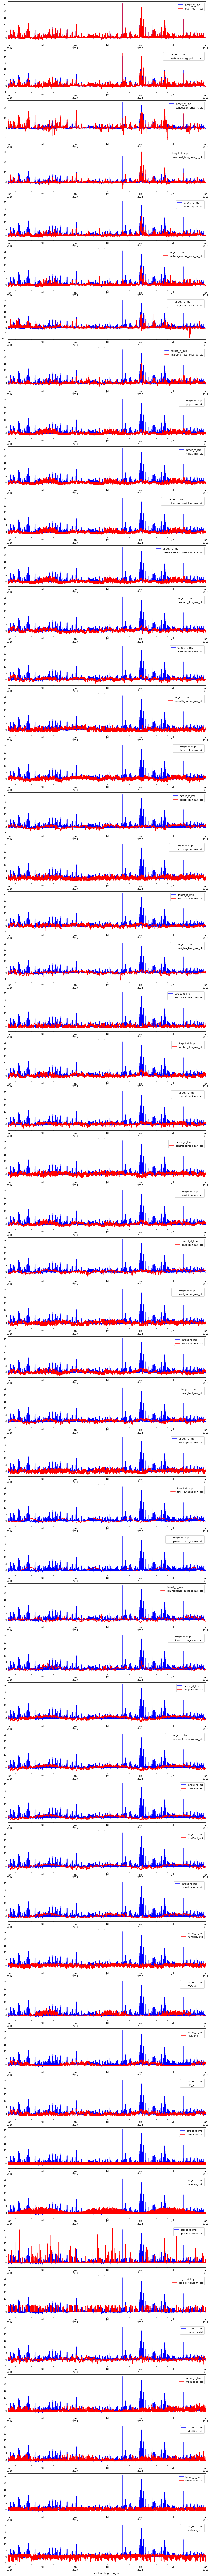

In [28]:
# plotting standardized real time price against other features
# to inspect for patterns and alignment with outliers
pd.plotting.register_matplotlib_converters()
fig, axes = plt.subplots(52, 1, figsize=(15, 200))
for i, col in enumerate(plot_df.columns[1:]):
    plot_df.plot(x='datetime_beginning_utc', y='total_lmp_rt_std',
                 color="b", label='target_rt_lmp', ax=axes[i])
    plot_df.plot(x='datetime_beginning_utc', y=col,
                 color="r", label=col, ax=axes[i])

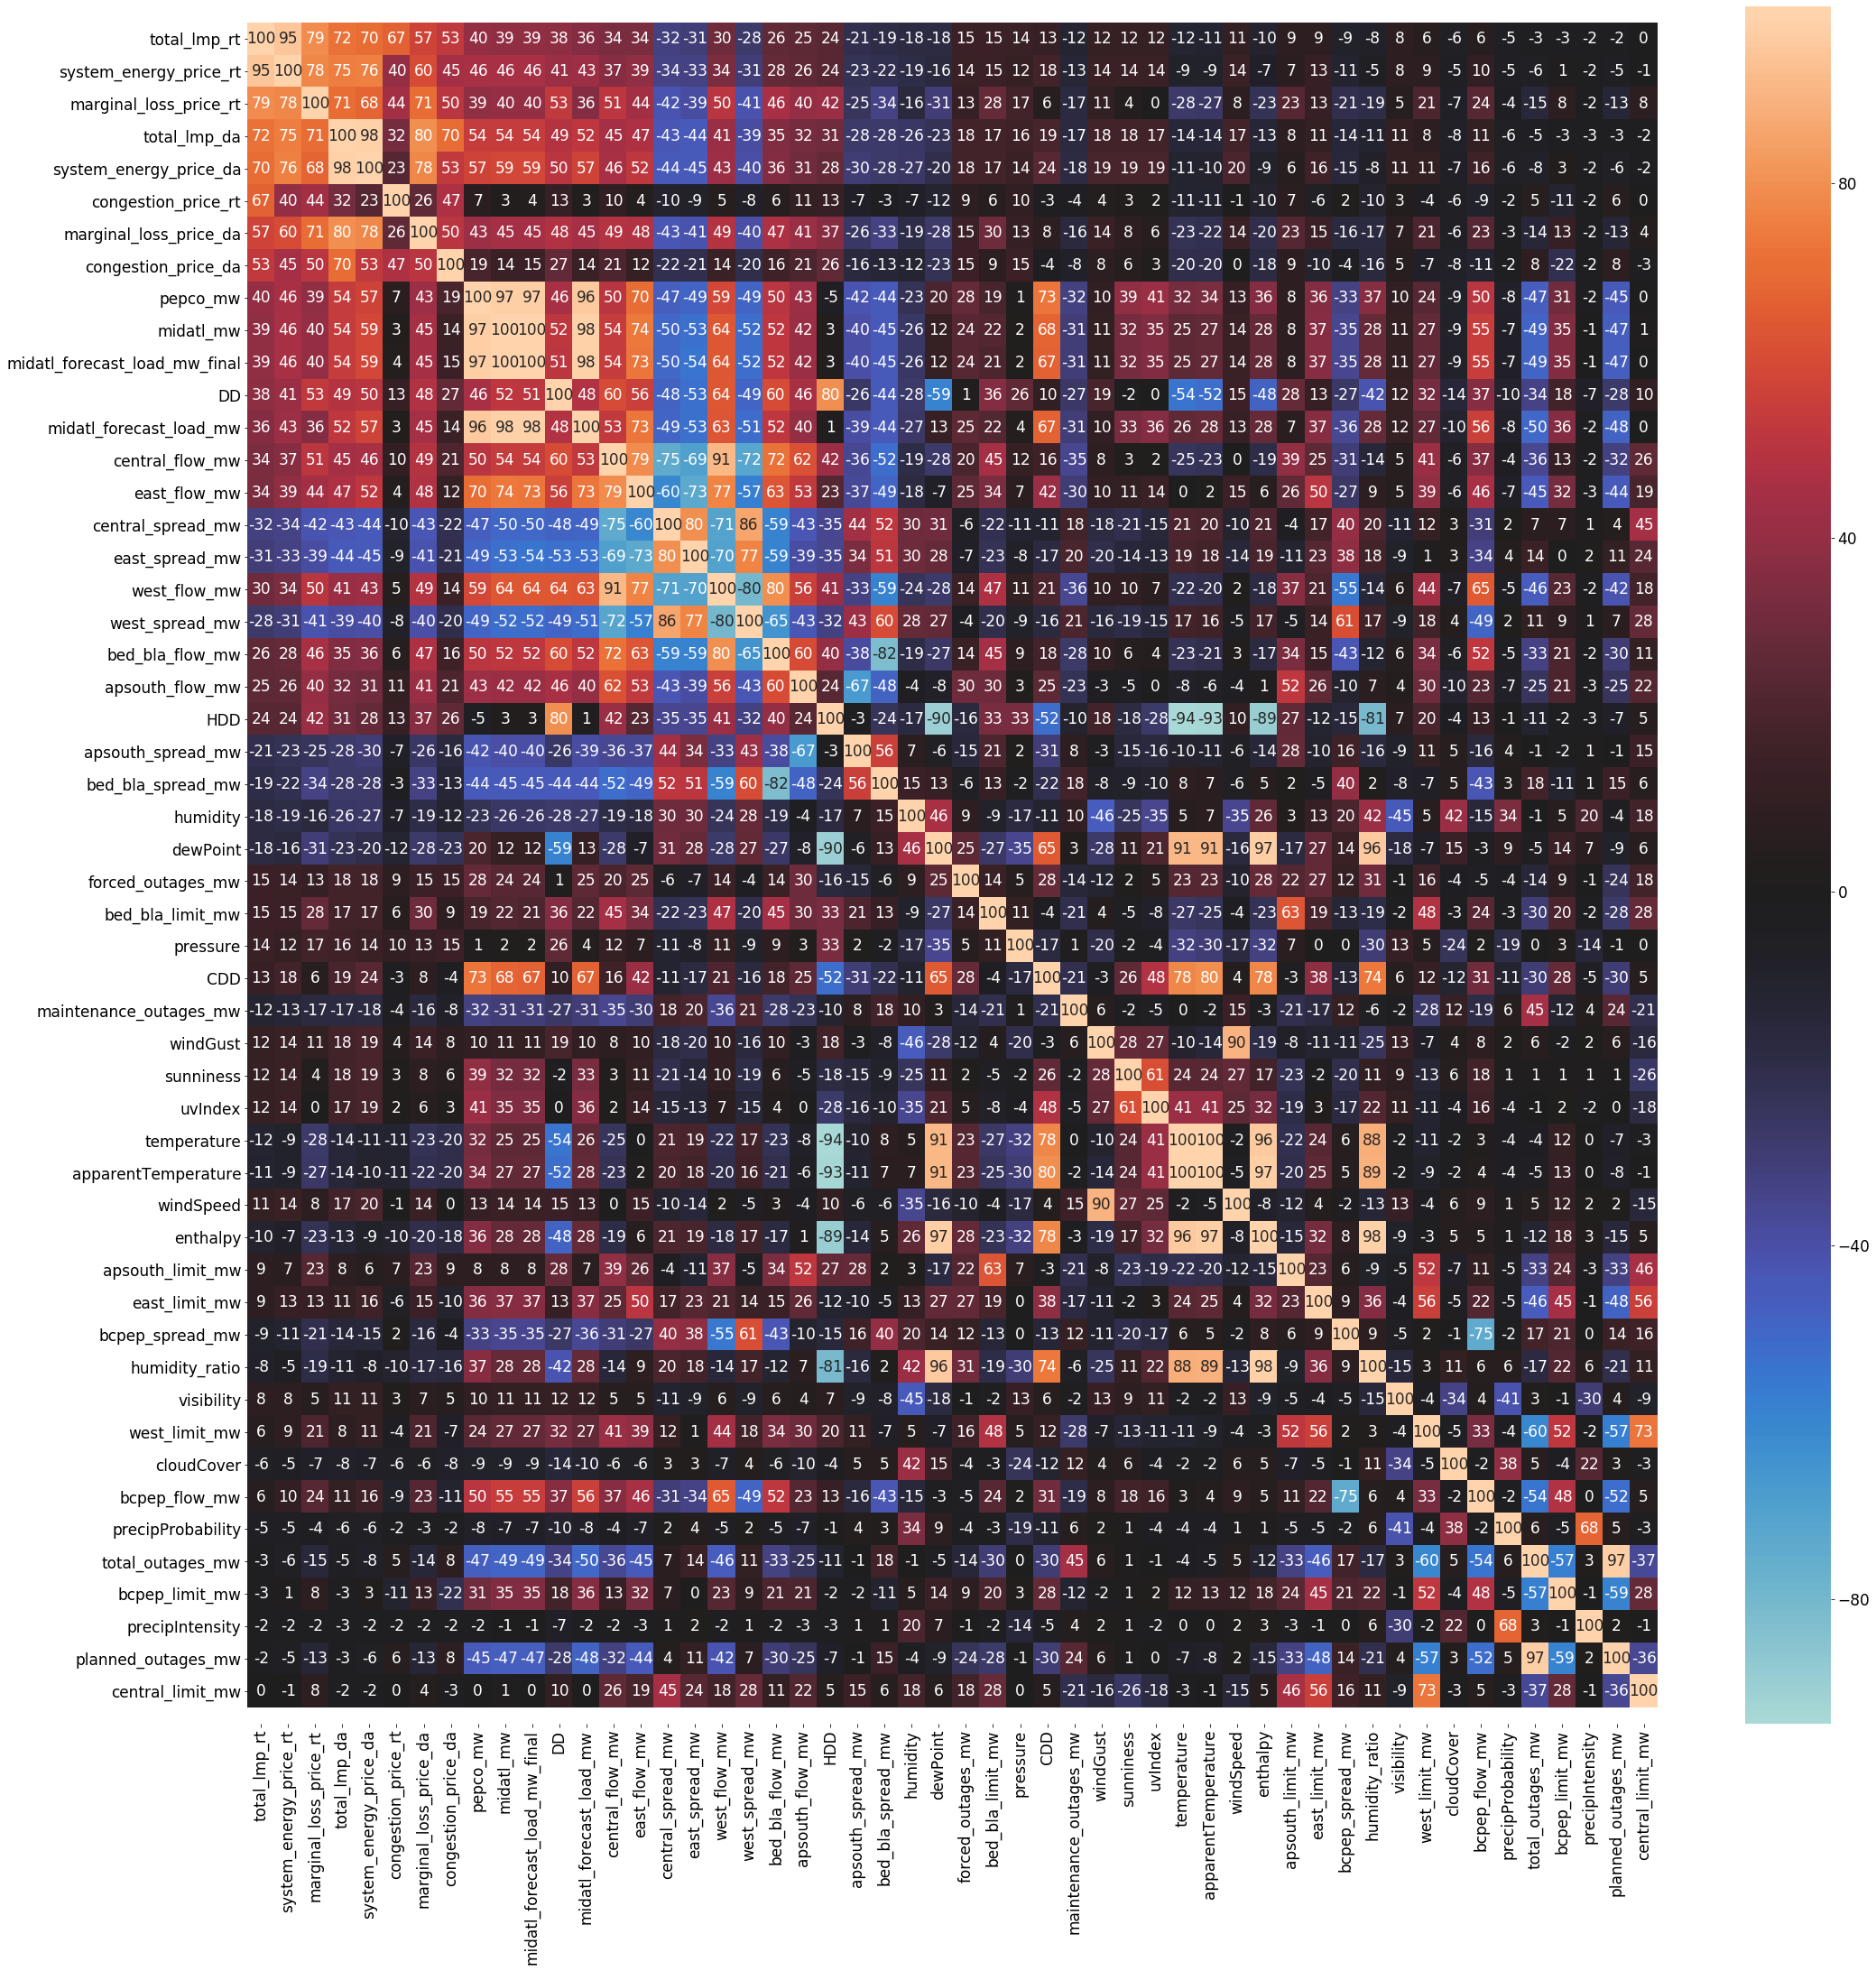

In [29]:
# now inspecting the correlation matrix of the features and real-time LMP

# creating the sort order
sorted_corr_series = train_data_std.corr().total_lmp_rt.abs().sort_values(ascending=False)
sorted_cols = list(sorted_corr_series.index)

# to allow for larger font sizes,
# the correlations are being rounded and multiplied by 100
sorted_corr_df = train_data_std[sorted_cols].corr().round(2)*100

plt.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(figsize = (35, 35))

sns.heatmap(sorted_corr_df.astype(int),
           center = 0, annot = True, fmt="d")

# a bug in the current version of matplotlib shifts the default ylim,
# and the code below corrects it
ax.set_ylim(len(train_data_std.columns)+0.5, -0.5);
plt.show;
plt.rcParams.update({'font.size': 10})

In [30]:
# creating a dataframe with Time Series, Real-Time LMP, and Selected Features
temporal = ['datetime_beginning_utc', 'datetime_beginning_ept']
# will consider separately forecasting each component of the price
price_targets = ['total_lmp_rt',
                 'system_energy_price_rt', 'congestion_price_rt', 'marginal_loss_price_rt']
# selected based on domain knowledge and correlation (visual and coefficient)
price_features = ['total_lmp_da', 'system_energy_price_da',
                  'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw',
                  'apsouth_flow_mw', 'apsouth_spread_mw',
                  'bcpep_flow_mw', 'bcpep_spread_mw',
                  'bed_bla_flow_mw', 'bed_bla_spread_mw',
                  'central_flow_mw', 'central_spread_mw',
                  'east_flow_mw', 'east_spread_mw',
                  'west_flow_mw', 'west_spread_mw',
                  'maintenance_outages_mw', 'forced_outages_mw',
                  'dewPoint', 'enthalpy', 'apparentTemperature',
                  'DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour',
                  'humidity', 'humidity_ratio']

# creating the dataframe
price_df = data[temporal+price_targets+price_features]

# Inspecting Features against Load (MW)

In [31]:
# dropping features that aren't available for longer term (multiple days) load (MW) forecasts,
# but are available for shorter term (multiple hours) price forecasts (LMP).
short_term_cols = ['total_lmp_rt_std',
                   'system_energy_price_rt_std', 'congestion_price_rt_std',
                   'marginal_loss_price_rt_std', 'total_lmp_da_std',
                   'system_energy_price_da_std', 'congestion_price_da_std',
                   'marginal_loss_price_da_std', 'midatl_mw_std',
                   'midatl_forecast_load_mw_std',
                   'apsouth_flow_mw_std', 'apsouth_limit_mw_std', 'apsouth_spread_mw_std',
                   'bcpep_flow_mw_std', 'bcpep_limit_mw_std', 'bcpep_spread_mw_std',
                   'bed_bla_flow_mw_std', 'bed_bla_limit_mw_std', 'bed_bla_spread_mw_std',
                   'central_flow_mw_std', 'central_limit_mw_std', 'central_spread_mw_std',
                   'east_flow_mw_std', 'east_limit_mw_std', 'east_spread_mw_std',
                   'west_flow_mw_std', 'west_limit_mw_std', 'west_spread_mw_std']

mw_plot_df = plot_df.drop(columns=short_term_cols)

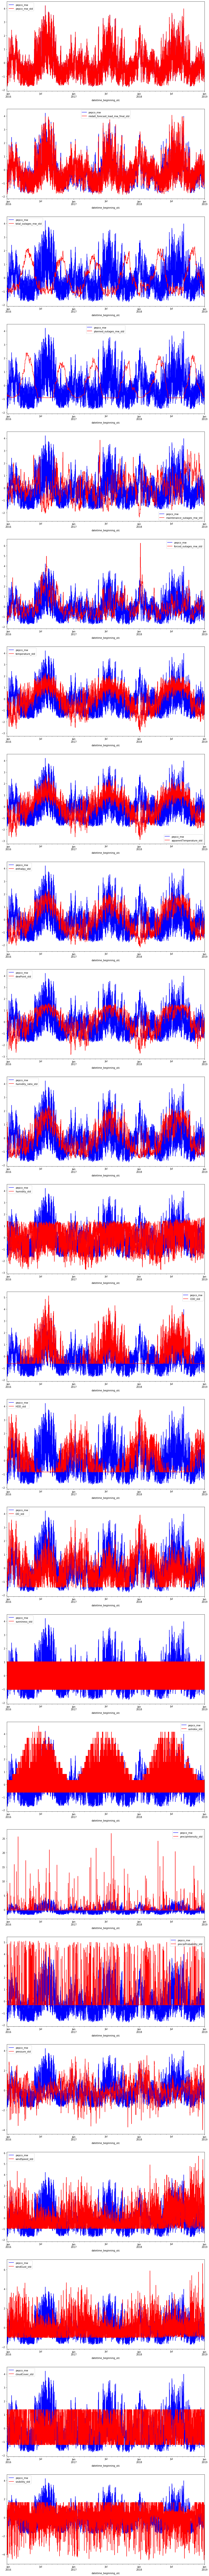

In [32]:
# plotting standardized pepco MW against other features
# to inspect for patterns and alignment with outliers
pd.plotting.register_matplotlib_converters()
fig, axes = plt.subplots(24, 1, figsize=(15, 200))
for i, col in enumerate(mw_plot_df.columns[1:]):
    mw_plot_df.plot(x='datetime_beginning_utc', y='pepco_mw_std',
                    color="b", label='pepco_mw', ax=axes[i])
    mw_plot_df.plot(x='datetime_beginning_utc', y=col,
                    color="r", label=col, ax=axes[i])

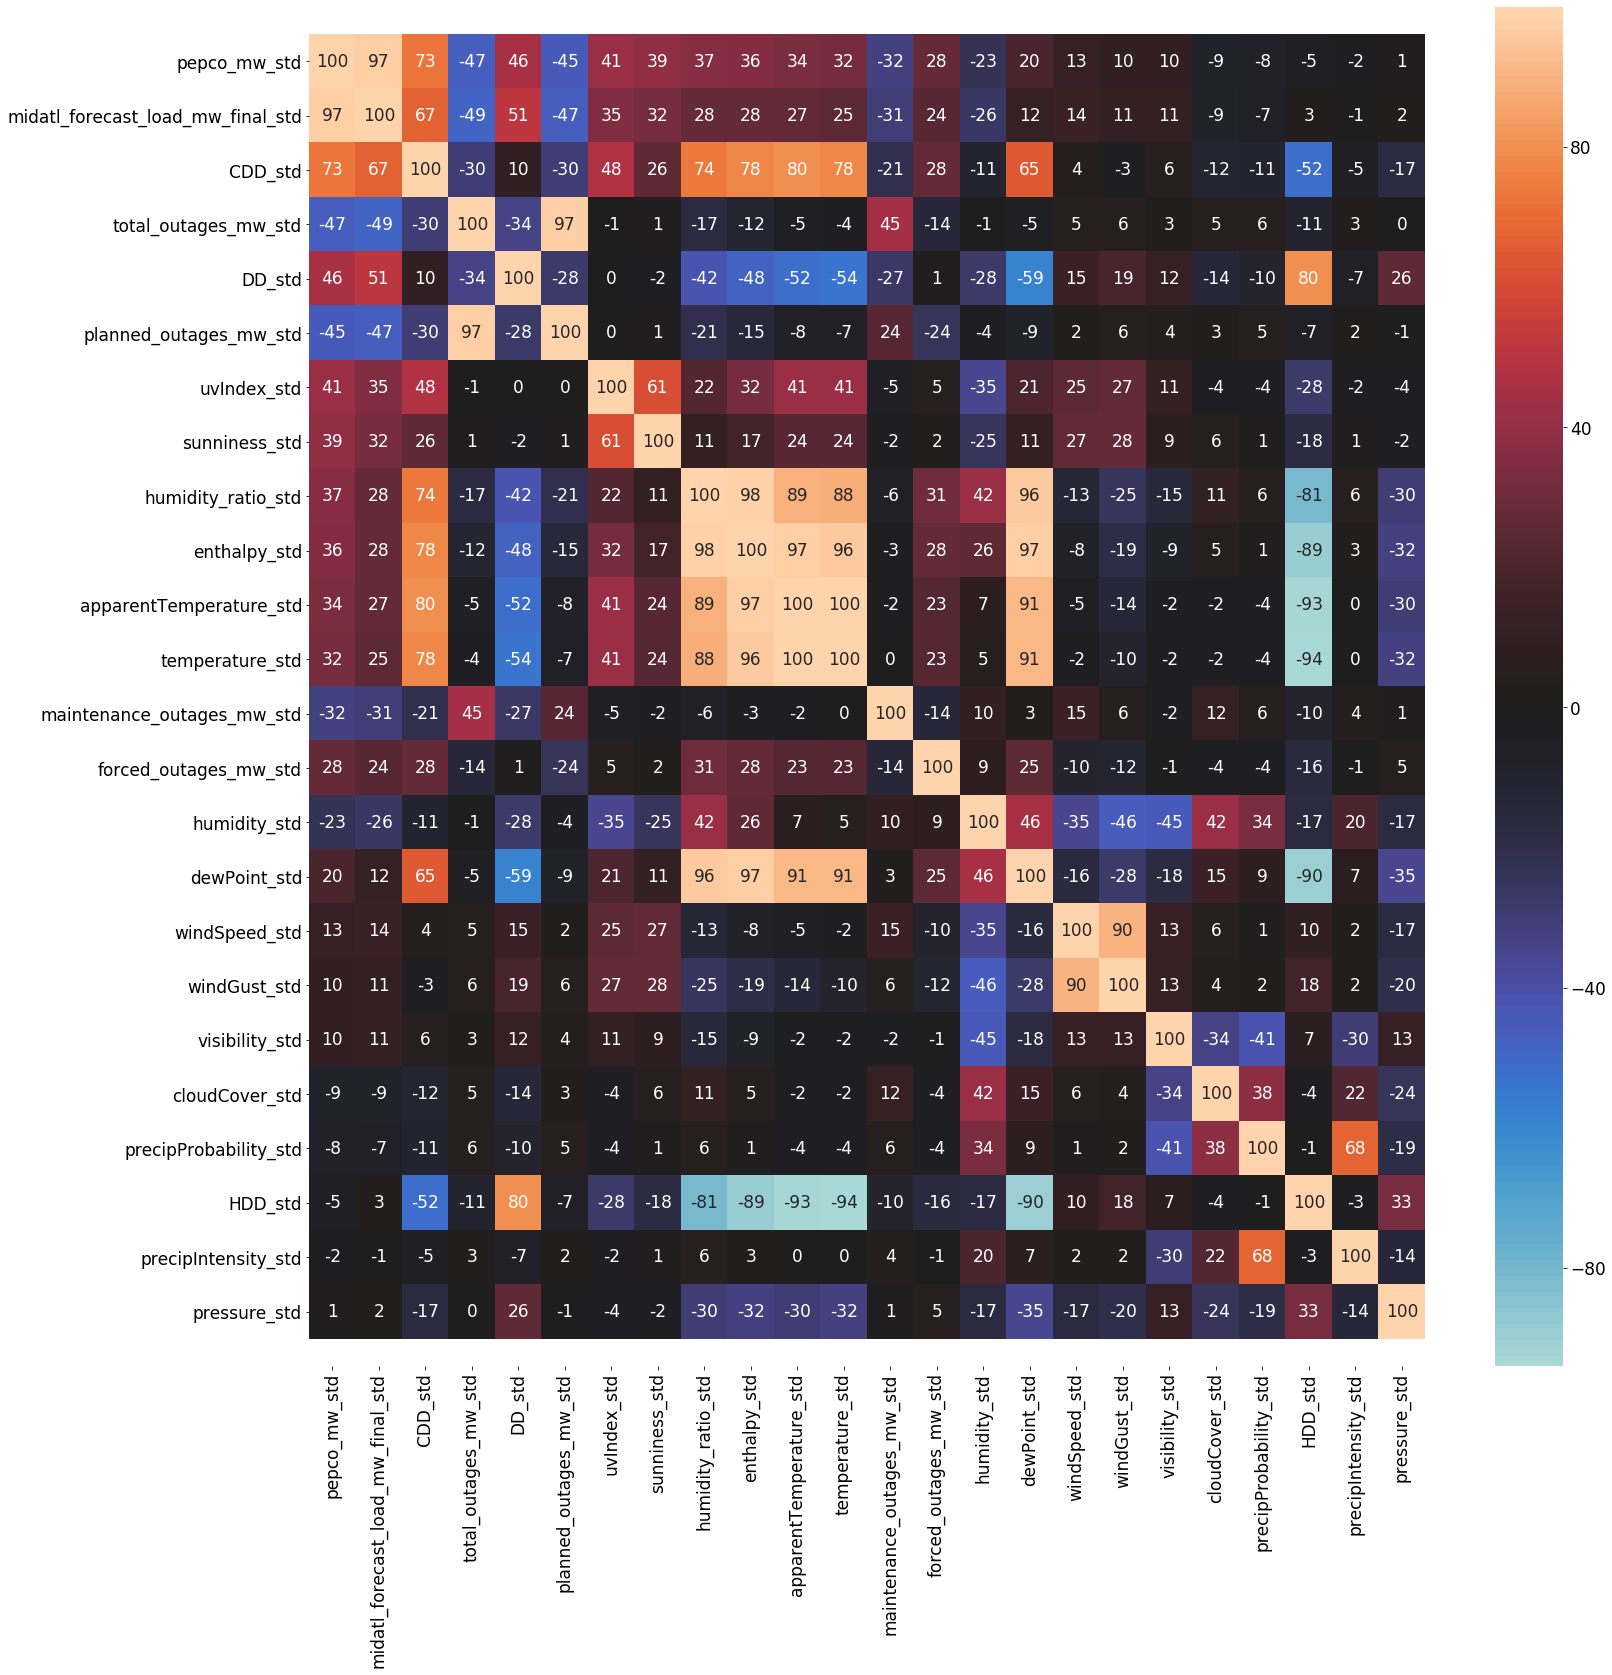

In [33]:
# now inspecting the correlation matrix of the features and real-time LMP

# creating the sort order
corr_data = mw_plot_df.drop(columns='datetime_beginning_utc')
sorted_corr_series = corr_data.corr().pepco_mw_std.abs().sort_values(ascending=False)
sorted_cols = list(sorted_corr_series.index)

# to allow for larger font sizes,
# the correlations are being rounded and multiplied by 100
sorted_corr_df = corr_data[sorted_cols].corr().round(2)*100

plt.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(figsize = (25, 25))

sns.heatmap(sorted_corr_df.astype(int),
           center = 0, annot = True, fmt="d")

# a bug in the current version of matplotlib shifts the default ylim,
# and the code below corr_data it
ax.set_ylim(len(corr_data.columns)+0.5, -0.5);
plt.show;
plt.rcParams.update({'font.size': 10})

In [34]:
# creating a dataframe with Time Series, PEPCO LMP, and Selected Features
temporal = ['datetime_beginning_utc', 'datetime_beginning_ept']
mw_targets = ['pepco_mw']
# selected based on domain knowledge and correlation (visual and coefficient)
mw_features = ['total_outages_mw', 'planned_outages_mw',
               'maintenance_outages_mw', 'forced_outages_mw',
               'enthalpy', 'apparentTemperature', 'dewPoint',
               'humidity', 'humidity_ratio', 'DD', 'CDD', 'HDD',
               'uvIndex', 'peak_hour']

# generating the dataframe
mw_df = data[temporal+mw_targets+mw_features]

# Exporting Final DataFrames to CSV

In [44]:
price_df.to_csv('data/processed/price_data.csv', index=False)

In [45]:
mw_df.to_csv('data/processed/mw_data.csv', index=False)